<a href="https://colab.research.google.com/github/iRevivalx/ICT2214-Web-Sec/blob/main/WebSec_CNN_C%2B%2B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries
This section contains all the necessary imports for the project

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# Load Dataset
This section where we load the dataset and preview the first few rows

In [ ]:
# Load the dataset
dataset = pd.read_csv("c++.csv", encoding="utf-8")

# Define the list of relevant CWEs
web_related_cwe = [
    'CWE-20', 'CWE-79', 'CWE-200', 'CWE-119',
    'CWE-399', 'CWE-416', 'CWE-264', 'CWE-362', 'CWE-284'
]

### **Fix the target column (Remove invalid values)**
dataset['target'] = pd.to_numeric(dataset['target'], errors='coerce')
dataset = dataset.dropna(subset=['target'])  # Remove rows where target is NaN
dataset['target'] = dataset['target'].astype(int)  # Convert target to integer

print("Fixed Target Value Counts:")
print(dataset["target"].value_counts())

# Safely process the 'cwe' column
def safe_process_cwe(val):
    if isinstance(val, str):
        try:
            result = eval(val)  # Convert string representation of list to actual list
            return result if isinstance(result, list) else [result]  # Ensure it's a list
        except:
            return []  # Return empty list if conversion fails
    elif isinstance(val, list):
        return val  # Already a list
    elif isinstance(val, (int, float)):  # If it's a number, convert to empty list
        return []
    else:
        return []  # Default to empty list

# Apply the function to 'cwe' column
dataset['cwe'] = dataset['cwe'].apply(safe_process_cwe)

# Ensure 'cwe' column is properly formatted
print(dataset['cwe'].head())

# Normalize CWE values (remove spaces and ensure uppercase)
dataset['cwe'] = dataset['cwe'].apply(lambda x: [cwe.strip().upper() for cwe in x])

# Filter dataset for vulnerable code (target=1) and relevant CWEs
filtered_dataset = dataset[(dataset['target'] == 1) &
                           (dataset['cwe'].apply(lambda x: any(cwe in web_related_cwe for cwe in x)))]

# Combine with non-vulnerable code (target=0) to balance the dataset
non_vulnerable_dataset = dataset[dataset['target'] == 0]

# Concatenate both datasets
final_dataset = pd.concat([filtered_dataset, non_vulnerable_dataset], ignore_index=True)

# Check resulting dataset size
print("Final dataset shape:", final_dataset.shape)

# Extract text and labels
X = final_dataset['func']
y = final_dataset['target']

# Print unique CWE values in the dataset
unique_cwes = dataset['cwe'].explode().unique()
print("Unique CWE values in dataset:", unique_cwes)

print("Number of vulnerable samples before filtering:", dataset[dataset['target'] == 1].shape[0])

# Check how many rows match the web-related CWE condition
dataset['has_web_cwe'] = dataset['cwe'].apply(lambda x: any(cwe in web_related_cwe for cwe in x))
print("Number of samples with web-related CWE:", dataset['has_web_cwe'].sum())

# Check how many vulnerable rows also match the CWE condition
filtered_dataset = dataset[(dataset['target'] == 1) & (dataset['has_web_cwe'])]
print("Filtered dataset shape:", filtered_dataset.shape)

print("Target Value Counts:")
print(dataset["target"].value_counts())


# Ensure X is not empty
if len(X) == 0 or len(y) == 0:
    raise ValueError("Filtered dataset is empty. Adjust filtering criteria.")




<ipython-input-88-d25b45180100>:2: DtypeWarning: Columns (5,6,8) have mixed types. Specify dtype option on import or set low_memory=False.
  dataset = pd.read_csv("c++.csv", encoding="utf-8")


Fixed Target Value Counts:
target
0    191440
1     13606
8         1
Name: count, dtype: int64
0           []
1    [CWE-264]
2           []
3    [CWE-787]
4    [CWE-787]
Name: cwe, dtype: object
Final dataset shape: (196127, 9)
Unique CWE values in dataset: [nan 'CWE-264' 'CWE-787' 'CWE-20' 'CWE-399' 'CWE-200' 'CWE-189' 'CWE-119'
 'CWE-16' 'CWE-94' 'CWE-362' 'CWE-269' 'CWE-400' 'CWE-193' 'CWE-120'
 'CWE-287' 'CWE-346' 'CWE-476' 'CWE-909' 'CWE-59' 'CWE-190' 'CWE-310'
 'CWE-22' 'CWE-415' 'CWE-772' 'CWE-401' 'CWE-134' 'CWE-617' 'CWE-79'
 'CWE-125' 'CWE-703' 'CWE-284' 'CWE-522' 'CWE-255' 'CWE-611' 'CWE-369'
 'CWE-61' 'CWE-732' 'CWE-89' 'CWE-416' 'CWE-755' 'CWE-835' 'CWE-241'
 'CWE-754' 'CWE-665' 'CWE-131' 'CWE-254' 'CWE-19' 'CWE-77' 'CWE-17'
 'CWE-209' 'CWE-273' 'CWE-295' 'CWE-18' 'CWE-763' 'CWE-129' 'CWE-681'
 'CWE-824' 'CWE-502' 'CWE-601' 'CWE-203' 'CWE-862' 'CWE-285' 'CWE-326'
 'CWE-347' 'CWE-252' 'CWE-532' 'CWE-388' 'CWE-74' 'CWE-770' 'CWE-191'
 'CWE-682' 'CWE-93' 'CWE-319' 'CWE-918' 

# Preprocessing
Perform preprocessing such as tokenization, padding, and label encoding.


In [ ]:
# Tokenize and pad the code snippets
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Initialize the tokenizer
tokenizer = Tokenizer(num_words=20000, oov_token="<OOV>")
tokenizer.fit_on_texts(X)

# Tokenize and pad sequences
X_tokenized = tokenizer.texts_to_sequences(X)
X_padded = pad_sequences(X_tokenized, maxlen=300, padding="post", truncating="post")

# Check shape after preprocessing
print("Shape of X_padded:", X_padded.shape)
print("Shape of y:", y.shape)

# Ensure dataset is non-empty before splitting
if X_padded.shape[0] == 0 or len(y) == 0:
    raise ValueError("Dataset is empty after preprocessing. Adjust filters or input data.")

Shape of X_padded: (196127, 300)
Shape of y: (196127,)


# Train/Test Split
Split the data into training and testing sets.


In [ ]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_padded, y, test_size=0.2, random_state=42)

# Handle missing values in y_train and y_test
y_train = pd.to_numeric(y_train, errors="coerce").fillna(0).astype(int)
y_test = pd.to_numeric(y_test, errors="coerce").fillna(0).astype(int)

# Convert to TensorFlow-compatible data types
X_train = np.array(X_train, dtype="float32")
X_test = np.array(X_test, dtype="float32")
y_train = np.array(y_train, dtype="int32")
y_test = np.array(y_test, dtype="int32")

# Model Training
Train the CNN model on the preprocessed data.


In [ ]:
# Build the CNN model
# Define input layer
input_layer = Input(shape=(300,))

# Embedding layer
embedding_layer = Embedding(input_dim=20000, output_dim=128, input_length=300)(input_layer)

# Apply dropout after embedding (optional, use if overfitting is severe)
embedding_dropout = Dropout(0.2)(embedding_layer)

# Convolutional layer
conv_layer = Conv1D(filters=128, kernel_size=5, activation="relu")(embedding_dropout)

# Pooling layer
pooling_layer = GlobalMaxPooling1D()(conv_layer)

# Fully connected dense layer
dense_layer = Dense(128, activation="relu")(pooling_layer)

# Apply dropout after first dense layer
dropout_layer1 = Dropout(0.3)(dense_layer)

# Another dense layer
dense_layer2 = Dense(64, activation="relu")(dropout_layer1)

# Apply dropout before output layer
dropout_layer2 = Dropout(0.5)(dense_layer2)

# Output layer for binary classification
output_layer = Dense(1, activation="sigmoid")(dropout_layer2)

# Compile the model
model = Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer=Adam(learning_rate=0.001), loss="binary_crossentropy", metrics=["accuracy"])

# Train the model
early_stopping = EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=32, callbacks=[early_stopping])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
4904/4904 ━━━━━━━━━━━━━━━━━━━━ 981s 200ms/step - accuracy: 0.9745 - loss: 0.1209 - val_accuracy: 0.9761 - val_loss: 0.0957
Epoch 2/10
4904/4904 ━━━━━━━━━━━━━━━━━━━━ 984s 200ms/step - accuracy: 0.9757 - loss: 0.0825 - val_accuracy: 0.9761 - val_loss: 0.0947
Epoch 3/10
4904/4904 ━━━━━━━━━━━━━━━━━━━━ 973s 198ms/step - accuracy: 0.9762 - loss: 0.0644 - val_accuracy: 0.9761 - val_loss: 0.1098
Epoch 4/10
4904/4904 ━━━━━━━━━━━━━━━━━━━━ 960s 196ms/step - accuracy: 0.9774 - loss: 0.0533 - val_accuracy: 0.9742 - val_loss: 0.1173
Epoch 5/10
4904/4904 ━━━━━━━━━━━━━━━━━━━━ 971s 194ms/step - accuracy: 0.9801 - loss: 0.0444 - val_accuracy: 0.9749 - val_loss: 0.1169


# Evaluation
Evaluate the model on the test set and visualize results.


1226/1226 ━━━━━━━━━━━━━━━━━━━━ 48s 39ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Accuracy: 97.61%
Precision: 95.28%
Recall: 97.61%
F1-score: 96.43%


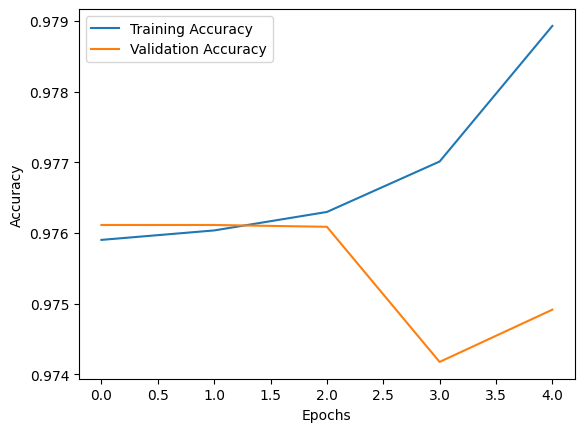

In [ ]:
# Get model predictions
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert probabilities to class labels

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred_classes)
precision = precision_score(y_test, y_pred_classes, average='weighted')  # Weighted for imbalanced datasets
recall = recall_score(y_test, y_pred_classes, average='weighted')
f1 = f1_score(y_test, y_pred_classes, average='weighted')

# Print metrics
print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision * 100:.2f}%")
print(f"Recall: {recall * 100:.2f}%")
print(f"F1-score: {f1 * 100:.2f}%")

# Plot training and validation accuracy
plt.plot(history.history["accuracy"], label="Training Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# Save the model
model.save("cnn_c++.h5")